---
<a name='title'></a>
# **<font color="Navy"> Física del Clima </font>**
## **<font color="RoyalBlue"> 1er semestre </font>**
### **<font color="DodgerBlue"> Notebook 3: Convección y CAPE </font>**
### Escuela Nacional de Ciencias de la Tierra
#### Semestre 2025-I

---

## **<font color="ForestGreen"> 1. Sondeos atmosféricos con MetPy </font>**

### Introducción

En este notebook, utilizaremos `MetPy` para graficar un sondeo atmosférico con características avanzadas. Un sondeo atmosférico nos permite visualizar el perfil vertical de la atmósfera, mostrando variables como la temperatura, la humedad y la presión en diferentes niveles. Esta información es fundamental para entender la estabilidad atmosférica y fenómenos convectivos.

**¿Por qué utilizar MetPy?**
`MetPy` es una herramienta poderosa para la manipulación y análisis de datos meteorológicos. Nos permite no solo graficar sondeos, sino también realizar cálculos avanzados como el nivel de condensación forzada (LCL) y el perfil de una parcela de aire basada en la superficie. Estas características son esenciales para entender la dinámica de la convección atmosférica y calcular parámetros importantes como el **CAPE** (Convective Available Potential Energy).

**Objetivos del notebook**
En este notebook aprenderemos a:
- Graficar un sondeo atmosférico con `MetPy`.
- Calcular el nivel de condensación forzada (LCL) y otros niveles importantes en la atmósfera.
- Graficar el perfil de una parcela de aire basada en la superficie.
- Interpretar la diferencia entre el perfil ambiental y el perfil de la parcela, y colorear las áreas que representan CAPE y CIN (Convective Inhibition).

Estos análisis nos permitirán comprender mejor los procesos convectivos y cómo la convección afecta la estabilidad atmosférica, la formación de tormentas y otros fenómenos relacionados con el clima.


In [1]:
import matplotlib.pyplot as plt
import pandas as pd

import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.plots import add_metpy_logo, SkewT
from metpy.units import units

Los datos de niveles superiores de la atmósfera se pueden obtener utilizando el paquete `siphon`, que permite descargar datos en tiempo real de estaciones meteorológicas y sondeos atmosféricos de varias fuentes, como los archivos de NOAA. Sin embargo, para este ejemplo, utilizaremos algunos de los datos de muestra que ofrece `MetPy`.

El uso de estos datos de ejemplo nos permitirá enfocarnos en aprender cómo manipular y graficar sondeos atmosféricos sin la necesidad de conectarnos a fuentes de datos en vivo. Esto también nos dará la flexibilidad de practicar con un conjunto de datos controlados y reproducibles, ideales para el aprendizaje y la enseñanza de conceptos como el cálculo del CAPE y la interpretación de perfiles atmosféricos.

In [2]:
# Definir los nombres de las columnas que se usarán en el DataFrame, correspondientes a las variables 
# medidas en el sondeo atmosférico: presión, altura, temperatura, punto de rocío, dirección del viento y velocidad del viento.
col_names = ['pressure', 'height', 'temperature', 'dewpoint', 'direction', 'speed']

# Leer el archivo de texto con los datos del sondeo atmosférico utilizando la función `read_fwf` de Pandas,
# que lee archivos de ancho fijo. Se omiten las primeras 5 filas y se seleccionan las columnas relevantes.
df = pd.read_fwf(get_test_data('may4_sounding.txt', as_file_obj=False),
                 skiprows=5, usecols=[0, 1, 2, 3, 6, 7], names=col_names)

# Eliminar cualquier fila que tenga valores NaN (faltantes) en las columnas de temperatura, 
# punto de rocío, dirección del viento y velocidad del viento. Luego, reiniciar el índice del DataFrame.
df = df.dropna(subset=('temperature', 'dewpoint', 'direction', 'speed'), how='all'
               ).reset_index(drop=True)


In [3]:
df

,pressure,height,temperature,dewpoint,direction,speed
0,959.0,345,22.2,19.0,160,18
1,931.3,610,20.2,17.5,165,40
2,925.0,671,19.8,17.1,165,38
3,899.3,914,18.4,16.9,175,39
4,892.0,984,18.0,16.8,178,39
5,867.9,1219,17.4,14.3,190,38
6,850.0,1397,17.0,12.5,195,38
7,814.0,1766,15.4,5.4,204,37
8,807.9,1829,15.4,1.2,205,37
9,790.0,2019,15.6,-11.4,211,40


Vamos a extraer los datos del conjunto de datos de ejemplo y asignarlos a variables individuales, a las que también les asignaremos unidades físicas correspondientes.

Este paso es crucial porque en meteorología, las unidades son fundamentales para interpretar correctamente los datos y realizar cálculos precisos. Por ejemplo, la presión atmosférica debe expresarse en hectopascales (hPa), las temperaturas en grados Celsius (°C) o Kelvin (K), y las velocidades del viento en metros por segundo (m/s). `MetPy` facilita la asignación y conversión de unidades, lo que garantiza que los cálculos sean consistentes y que las gráficas tengan el contexto físico adecuado. Al extraer y asignar unidades a las variables como la presión, temperatura, punto de rocío y viento, podremos trabajar directamente con datos con sentido físico, lo que es esencial para los análisis meteorológicos.



In [6]:
# Extraer la columna de presión del DataFrame y asignar las unidades de hectopascales (hPa).
p = df['pressure'].values * units.hPa

# Extraer la columna de temperatura y asignar las unidades de grados Celsius (°C).
T = df['temperature'].values * units.degC

# Extraer la columna de punto de rocío y asignar las unidades de grados Celsius (°C).
Td = df['dewpoint'].values * units.degC

# Extraer la columna de velocidad del viento y asignar las unidades de nudos (knots).
wind_speed = df['speed'].values * units.knots

# Extraer la columna de dirección del viento y asignar las unidades de grados.
wind_dir = df['direction'].values * units.degrees

# Calcular las componentes del viento en las direcciones U (este-oeste) y V (norte-sur) 
# usando la velocidad y dirección del viento, con la función `wind_components` de MetPy.
u, v = mpcalc.wind_components(wind_speed, wind_dir)

El nivel de condensación forzada (LCL) es el punto en la atmósfera donde una parcela de aire ascendente se enfría lo suficiente como para que su temperatura iguale al punto de rocío, lo que provoca la condensación del vapor de agua. El cálculo del LCL es esencial para identificar el nivel en el que se forma la nube en un proceso convectivo. Saber el LCL es crucial para predecir el desarrollo de nubes y tormentas, ya que este nivel marca la transición entre el ascenso seco adiabático de la parcela y el ascenso húmedo adiabático, una vez que comienza la condensación.

En la siguiente línea de código, vamos a calcular el nivel de condensación forzada (LCL) usando los valores iniciales de presión, temperatura y punto de rocío de la superficie.

In [10]:
# Calcular el nivel de condensación forzada (LCL) en términos de presión y temperatura,
# utilizando los valores de presión (p[0]), temperatura (T[0]), y punto de rocío (Td[0]) 
# en la superficie (primer nivel de los datos del sondeo).
lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], T[0], Td[0])

In [11]:
print(lcl_pressure,lcl_temperature)

914.8213254198571 hectopascal 18.24686942595514 degree_Celsius


(-20.0, 30.0)

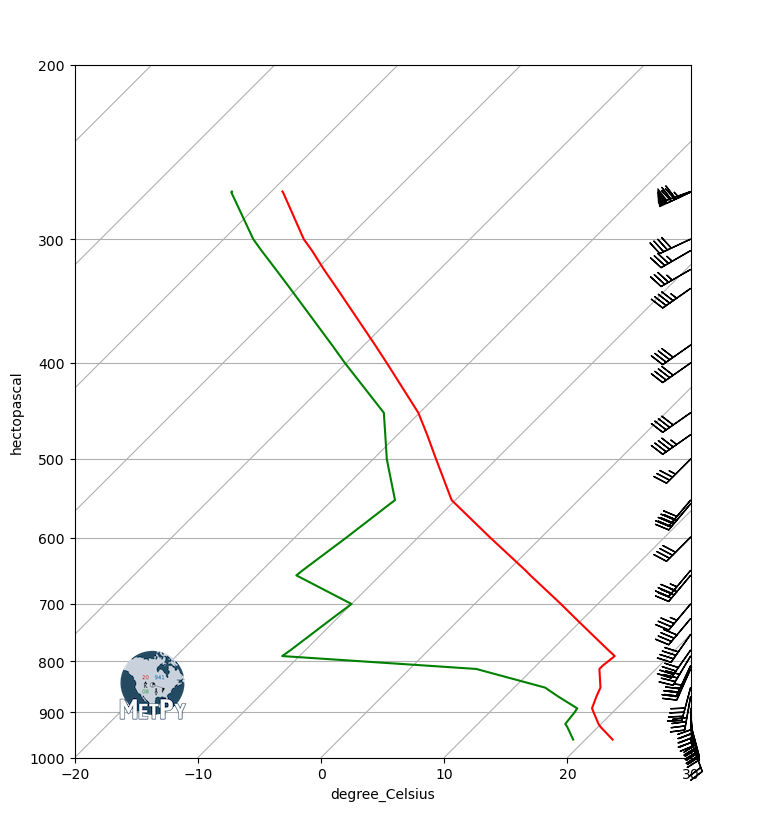

In [14]:
# Crear una figura de tamaño 9x9 pulgadas para la gráfica.
fig = plt.figure(figsize=(9, 9))

# Agregar el logotipo de MetPy a la figura para la personalización y presentación de la gráfica.
add_metpy_logo(fig, 115, 100)

# Crear un gráfico Skew-T, que es una representación típica de un sondeo atmosférico.
# La rotación de 45 grados es el ajuste estándar para inclinar las isobaras (líneas de presión).
skew = SkewT(fig, rotation=45)

# Graficar los datos en la figura, comenzando con las líneas de temperatura y punto de rocío.

# Graficar el perfil de temperatura (T) en función de la presión (p), usando una línea roja ('r').
# El eje Y tiene una escala logarítmica, como es típico en los gráficos meteorológicos,
# ya que la presión atmosférica decrece exponencialmente con la altura.
skew.plot(p, T, 'r')

# Graficar el perfil del punto de rocío (Td) en función de la presión (p), con una línea verde ('g').
skew.plot(p, Td, 'g')

# Graficar las barbas de viento, que representan la velocidad y dirección del viento
# a diferentes niveles de presión (alturas), usando los valores de las componentes u y v del viento.
skew.plot_barbs(p, u, v)

# Configurar los límites del eje Y para que la gráfica abarque desde 1000 hPa hasta 100 hPa,
# es decir, desde la superficie hasta los niveles superiores de la atmósfera.
skew.ax.set_ylim(1000, 200)

# Configurar los límites del eje X, para que la temperatura en la gráfica oscile entre -40°C y 60°C.
skew.ax.set_xlim(-20, 30)


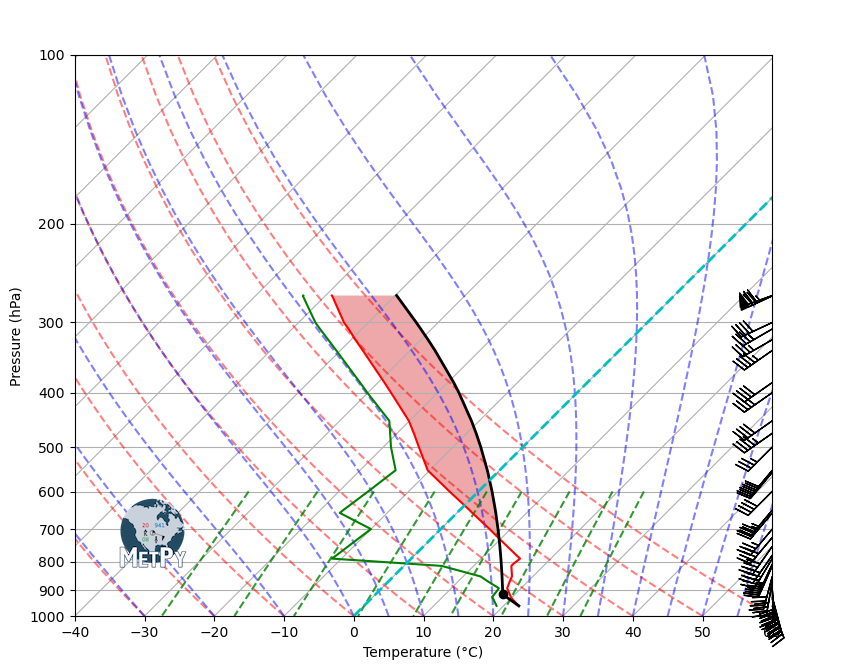

In [4]:
fig = plt.figure(figsize=(9, 9))
add_metpy_logo(fig, 115, 100)
skew = SkewT(fig, rotation=45)

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot.
skew.plot(p, T, 'r')
skew.plot(p, Td, 'g')
skew.plot_barbs(p, u, v)
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-40, 60)

# Set some better labels than the default
skew.ax.set_xlabel(f'Temperature ({T.units:~P})')
skew.ax.set_ylabel(f'Pressure ({p.units:~P})')

# Calculate LCL height and plot as black dot. Because `p`'s first value is
# ~1000 mb and its last value is ~250 mb, the `0` index is selected for
# `p`, `T`, and `Td` to lift the parcel from the surface. If `p` was inverted,
# i.e. start from low value, 250 mb, to a high value, 1000 mb, the `-1` index
# should be selected.

skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black')

# Calculate full parcel profile and add to plot as black line
prof = mpcalc.parcel_profile(p, T[0], Td[0]).to('degC')
skew.plot(p, prof, 'k', linewidth=2)

# Shade areas of CAPE and CIN
skew.shade_cin(p, T, prof, Td)
skew.shade_cape(p, T, prof)

# An example of a slanted line at constant T -- in this case the 0
# isotherm
skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)

# Add the relevant special lines
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()

# Show the plot
plt.show()